<a href="https://colab.research.google.com/github/ancestor9/Practical-Machine-Learning-for-Computer-Vision-/blob/main/03a_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib
from IPython.display import Markdown as md
_nb_loc = "03_image_models/03a_transfer_learning.ipynb" # change to reflect your notebook
_nb_title = "5 Flowers Image Classification with Transfer Learning" # change to reflect your notebook
_nb_message = "In this notebook, we show how to build a neural network to classify the tf-flowers (5 flowers) dataset by using a pre-trained image embedding." # change to reflect your notebook
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=5+Flowers+Image+Classification+with+Transfer+Learning&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F03_image_models%2F03a_transfer_learning.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/03_image_models/03a_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/03_image_models/03a_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/03_image_models/03a_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>5 Flowers Image Classification with Transfer Learning</h1>In this notebook, we show how to build a neural network to classify the tf-flowers (5 flowers) dataset by using a pre-trained image embedding.

## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.19.0
Found GPU at: /device:GPU:0


In [9]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# # Call model.predict() on a few images in the evaluation dataset
# def plot_predictions(model, dataset):
#   f, ax = plt.subplots(3, 5, figsize=(25,15))
#   # Iterate over the dataset directly instead of reading from a file
#   for idx, (img, label) in enumerate(dataset.take(15)):
#     # Resize the image to the expected input size
#     img_resized = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
#     ax[idx//5, idx%5].imshow((img_resized.numpy()));
#     # The image needs to be expanded to have a batch dimension for prediction
#     batch_image = tf.expand_dims(img_resized, axis=0)
#     batch_pred = model.predict(batch_image)
#     pred = batch_pred[0]
#     # Assuming CLASS_NAMES is available in the scope
#     label_name = CLASS_NAMES[label.numpy()]
#     pred_label_index = tf.math.argmax(pred).numpy()
#     pred_label_name = CLASS_NAMES[pred_label_index]
#     prob = pred[pred_label_index]
#     ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label_name, pred_label_name, prob))
#     ax[idx//5, idx%5].axis('off')

# def show_trained_weights(model):
#   # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
#   LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
#   WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

#   f, ax = plt.subplots(1, 5, figsize=(15,15))
#   for flower in range(len(CLASS_NAMES)):
#     weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
#     min_wt = tf.math.reduce_min(weights).numpy()
#     max_wt = tf.math.reduce_max(weights).numpy()
#     flower_name = CLASS_NAMES[flower]
#     print("Scaling weights for {} in {} to {}".format(
#         flower_name, min_wt, max_wt))
#     weights = (weights - min_wt)/(max_wt - min_wt)
#     ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
#     ax[flower].set_title(flower_name);
#     ax[flower].axis('off')

In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Transfer Learning with MobileNet

Let's load a pre-trained model and use it
instead of the Flattened layer as our first layer.

In [3]:
import tensorflow_datasets as tfds

# 데이터셋 로드
ds_train = tfds.load('tf_flowers', split='train[:80%]', as_supervised=True)
ds_eval = tfds.load('tf_flowers', split='train[80%:]', as_supervised=True)

# decode_csv 함수 대신 이미지 전처리 함수 정의
def preprocess_image(image, label):
    # 이미지 리사이즈 (원하는 크기로 조정)
    image = tf.image.resize(image, [224, 224])
    # 정규화 (0-1 범위로)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# 데이터셋 전처리 및 배치
train_dataset = (ds_train
                 .map(preprocess_image)
                 .shuffle(1000)
                 .batch(batch_size=32)
                 .prefetch(tf.data.AUTOTUNE))

eval_dataset = (ds_eval
                .map(preprocess_image)
                .batch(32)
                .prefetch(tf.data.AUTOTUNE))

In [4]:
# 데이터셋 정보 확인
info = tfds.builder('tf_flowers').info
print(info)
print(f"클래스 수: {info.features['label'].num_classes}")
print(f"클래스 이름: {info.features['label'].names}")

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)
클래스 수: 5
클래스 이름: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [5]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import os

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# 이미지 전처리 함수 정의
def preprocess_image(image, label):
    """TF Flowers 데이터셋 이미지 전처리"""
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size=32,
                       lrate=0.001,
                       l1=0.,
                       l2=0.,
                       num_hidden=16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    # TensorFlow Datasets로 데이터 로드
    ds_train = tfds.load('tf_flowers', split='train[:80%]', as_supervised=True)
    ds_eval = tfds.load('tf_flowers', split='train[80%:]', as_supervised=True)

    # 데이터셋 전처리 및 배치
    train_dataset = (ds_train
                     .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
                     .shuffle(1000)
                     .batch(batch_size)
                     .prefetch(tf.data.AUTOTUNE))

    eval_dataset = (ds_eval
                    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
                    .batch(32)
                    .prefetch(tf.data.AUTOTUNE))

    # Use the Keras functional API to define the model
    input_layer = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='input_image')
    mobilenet_embedding_layer = hub.KerasLayer(
        "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
        trainable=False,
        name='mobilenet_embedding')
    mobilenet_embedding = tf.keras.layers.Lambda(
        lambda x: mobilenet_embedding_layer(x),
        name='lambda_mobilenet')(input_layer)

    dense_hidden = tf.keras.layers.Dense(num_hidden,
                                        kernel_regularizer=regularizer,
                                        activation='relu',
                                        name='dense_hidden')(mobilenet_embedding)
    flower_prob = tf.keras.layers.Dense(len(CLASS_NAMES),
                                       kernel_regularizer=regularizer,
                                       activation='softmax',
                                       name='flower_prob')(dense_hidden)

    model = tf.keras.Model(inputs=input_layer, outputs=flower_prob, name='flower_classification')

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(
                      from_logits=False),
                  metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=5)
    training_plot(['loss', 'accuracy'], history)
    return model

In [6]:
# This cell was empty and might have caused an error.

Model: "flower_classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_mobilenet (Lambda)       │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 16)             │        20,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flower_prob (Dense)             │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,581 (80.39 KB)

 Trainable params: 20,581 (80.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.5722 - loss: 1.1185 - val_accuracy: 0.8597 - val_loss: 0.4316
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8791 - loss: 0.3549 - val_accuracy: 0.8992 - val_loss: 0.3102
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9325 - loss: 0.2378 - val_accuracy: 0.8965 - val_loss: 0.3198
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9392 - loss: 0.2013 - val_accuracy: 0.9046 - val_loss: 0.2786
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9599 - loss: 0.1504 - val_accuracy: 0.9210 - val_loss: 0.2722


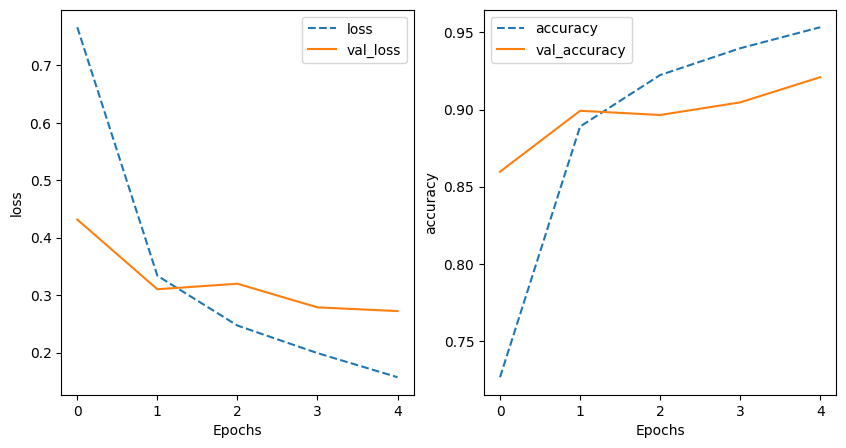

In [10]:
model = train_and_evaluate()

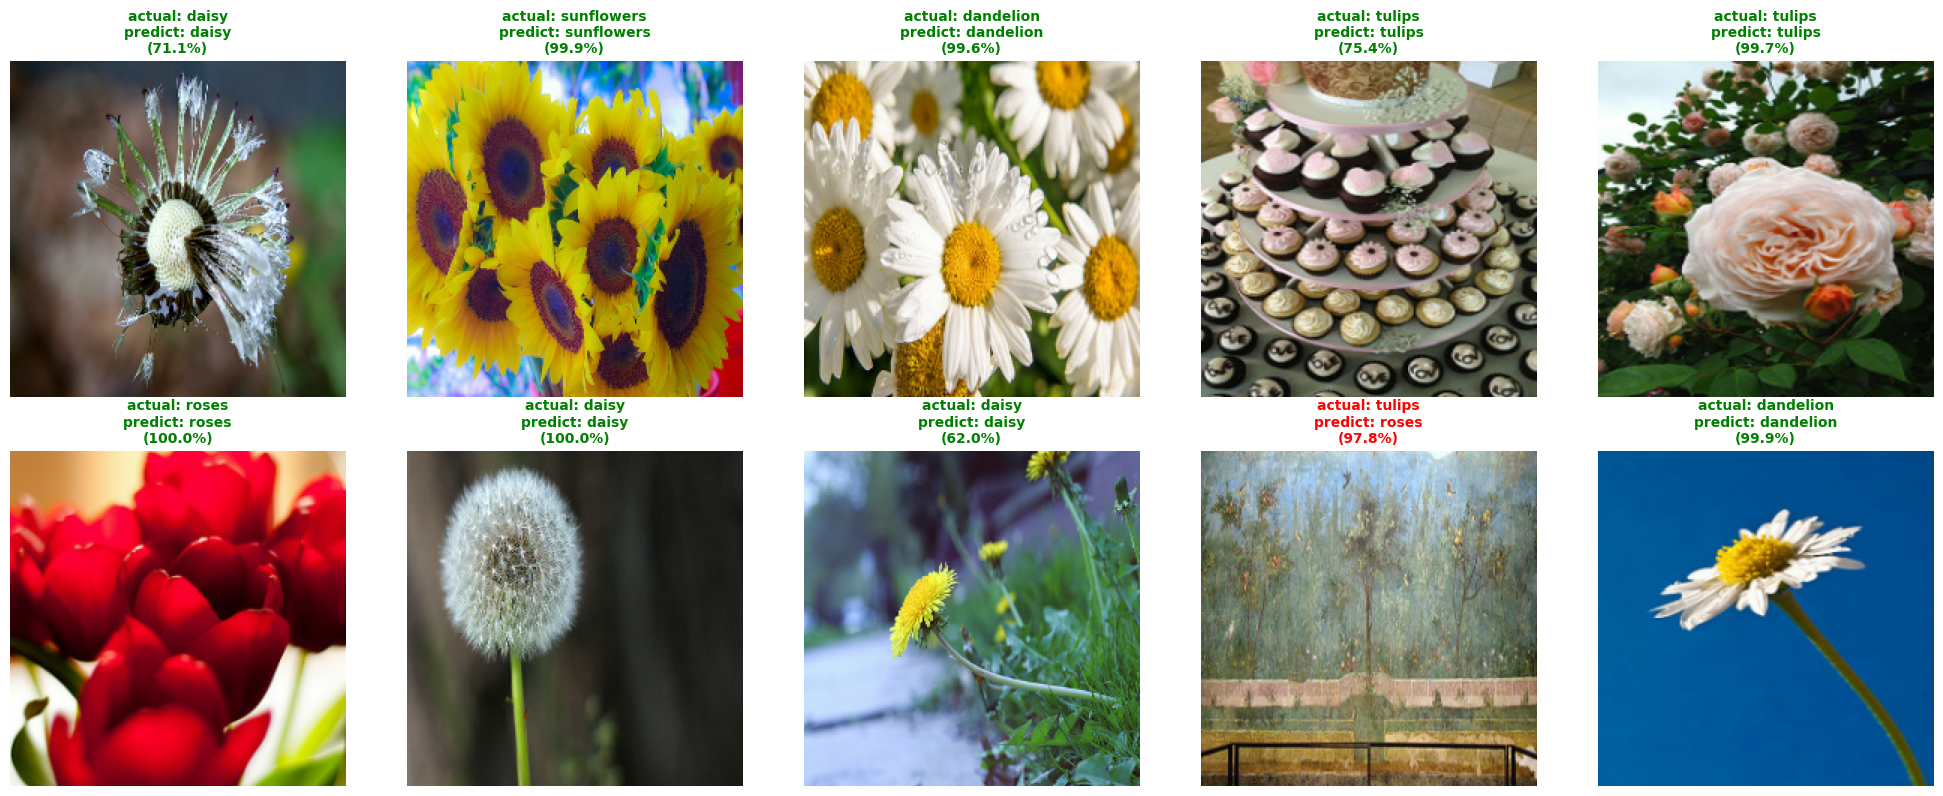


정확도: 9/10 (90.0%)


In [11]:
def visualize_predictions_simple(model, eval_dataset, class_names, num_samples=10):
    """간단한 버전"""
    # unbatch하여 개별 샘플로 만들기
    unbatched_dataset = eval_dataset.unbatch()

    # 무작위 샘플 선택
    sample_dataset = unbatched_dataset.shuffle(1000).take(num_samples)

    images = []
    labels = []
    for img, label in sample_dataset:
        images.append(img.numpy())
        labels.append(label.numpy())

    images = np.array(images)
    labels = np.array(labels)

    # 예측
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)

    # 시각화
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for idx in range(num_samples):
        axes[idx].imshow(images[idx])
        axes[idx].axis('off')

        true_label = class_names[labels[idx]]
        pred_label = class_names[predicted_classes[idx]]
        confidence = predictions[idx][predicted_classes[idx]] * 100

        color = 'green' if labels[idx] == predicted_classes[idx] else 'red'

        axes[idx].set_title(
            f'actual: {true_label}\npredict: {pred_label}\n({confidence:.1f}%)',
            fontsize=10, color=color, weight='bold'
        )

    plt.tight_layout()
    plt.show()

    # 통계
    correct = np.sum(labels == predicted_classes)
    print(f"\n정확도: {correct}/{num_samples} ({correct/num_samples*100:.1f}%)")


# 사용
visualize_predictions_simple(model, eval_dataset, CLASS_NAMES, num_samples=10)

## License
Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.